# Latency Plotting Code Boilerplate Notebook

Author: Jun Ho Lee  
Last Update: 10/6/2019


____
<a id='Goals'></a>

### General Objective:
Calculate the latencies and plot the cdf (cumulative distribution function)

### Important Note:

> Do **NOT** save or modify the original csv file!!! 
Modifying the csv file will lead to truncation of leading zeros in the file, which will mess up the analysis! 


<a id='Table of Contents'></a>
___
* * * * * * * * * 

0. <a href='#Goals'>Objectives and Pipeline</a>

## Table of Contents


1. <a href='#Function List'>List of Functions</a>

2. <a href='#data wrangling'>Initial Data Wrangling</a>

3. <a href='#metric output'>Metric Output</a>

3. <a href='#metric checkpoint'>Save Metric Output to CSV (Checkpoint)</a>



**Appendix:**  
1. <a href='#Event Code'>Event Codes</a> (Run this First!!)

<a id='Function List'></a>
___
    
### 1. List of Functions

*A. <a href='#data extraction'>Data Extraction and Parsing</a>*
1. <a href='#return_header_dict'>return-multi-header-dict</a>
2. <a href='#return_body_df'>return-multi-body-df</a>
3. <a href='#get_start_end_time'>get-start-end-time</a>
4. <a href='#return_multi_dt'>return-multi-dt-df</a> 
5. <a href='#fill_counter_datetime_col'>fill-counter-datetime-col</a> 
6. <a href='#return_multi_parsed_dt'>return-multi-parsed-dt-df</a>
7. <a href='#final wrapper function'>final-m-header-and-parsed-dt-df</a>


*B. <a href='#metric calculation'>Metric Calculations</a>*
1. <a href='#counts_during_window'>counts-during-window</a>
2. <a href='#count_events'>count-events</a>



### *For Function Testing Purposes*

###### Import Basic Libraries

In [1]:
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from datetime import datetime
# import matplotlib.pyplot as plt
# import seaborn as sns

file = "../0923 TIR.csv" 
test_multi_df = pd.read_csv(file, header=[0,1], index_col=[0])

# # To test out the effect of saving on a csv file 
# file1 = "0903 w_delay.csv" 
# test1 = pd.read_csv(file1, header=[0,1], index_col=[0])

In [2]:
# df_test1 = test1['6']
# df_test1.head(10)
# test1.info()

<a id='data extraction'></a>
___
#### A. Data Extraction and Parsing


<a id='return_header_dict'></a>

**1: return_multi_header_dict (multi_df)**

- :**multi_df:** multilevel dataframe that we created from "import_files.py"
- **:return:** `m_head_dict`: nested dictionary of headers $\rightarrow$ {box number(keys): {header info(values)}}

In [3]:
# # Will only need the initial "MultiLevel Dataframe" to run subsequent codes!!
def return_multi_header_dict(multi_df):
    
    m_head_dict = {}
    box_numbers = multi_df.columns.levels[0]  # Returns a "Frozen List" 
    sorted_box_nums = natsorted(box_numbers) # outputs a list of sorted box numbers

    for i in range(len(sorted_box_nums)):
        box_num = sorted_box_nums[i]
        ind_df = multi_df.loc[:, box_num]  # individual dataframe (box is type 'string')

        ind_df = ind_df.dropna(how='all')

        start_code_idx = ind_df.index[ind_df.event_code == '0113'].tolist()[0]  # the list will only contain ONE element
        end_date_info = ind_df[-2:]  # last two rows will always be end date info

        head = ind_df[:start_code_idx]

        ind_head = pd.concat([head, end_date_info], axis=0)   # header dictionary requires end date/time info so need to concatenate the top and bottom dfs
        ind_head['timestamp'] = ind_head['timestamp'].str.strip()

        # # {first column: second column}
        ind_header_dict = {row[0]: row[1] for row in ind_head.values}  # .values --> transforms into numpy array

        m_head_dict[box_num] = ind_header_dict

    return m_head_dict


In [4]:
test_m_head_dict = return_multi_header_dict(test_multi_df)

<a href='#Function List'>Back to List of Functions</a>

In [5]:
# test_multi_df
# pd.DataFrame.from_dict(test_m_head_dict, orient='index')

<a id='return_body_df'></a>

**2: return_multi_body_df (multi_df):**

- **:multi_df:** multilevel dataframe that we created from "import_files.py"
- **:returns:** `m_body_df`: multilevel dataframe of the BODY portion of data  

*BODY*: FROM the first IR initialization (9070) TO the second to last row of the original dataframe (excluding end date/time)

In [8]:
# Will only need the initial "MultiLevel Dataframe" to run subsequent codes!!

def return_multi_body_df(multi_df, columns):

    result = []; box_arr = []
    box_numbers = multi_df.columns.levels[0]
    sorted_box_nums = natsorted(box_numbers) # outputs a list of sorted box numbers
    
    for i in range(len(sorted_box_nums)):  # for all the boxes, (outermost index is box number)
        box_num = sorted_box_nums[i]
        ind_df = multi_df.loc[:, box_num]  # individual dataframe

        ind_df = ind_df.dropna(how='all')
#         ind_df['event_code'] = ind_df['event_code'].astype('str')  # Changed

        # Extracting ACTUAL BODY
        header_end_idx = ind_df.loc[ind_df[ind_df.columns[0]] == '9070'].index[0]
        body_start_idx = header_end_idx + 1

        body = ind_df[body_start_idx:-2].reset_index(drop=True)
        body.loc[:,'timestamp'] = pd.to_numeric(body['timestamp'])
        body['event_string'] = body['event_code'].map(event_code_dict)

        body = body[columns]  # 4 columns or 3 columns

        box_arr.append(box_num)
        result.append(body)

    m_body_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])

    return m_body_df


<a href='#Event Code'>Event Codes</a> (Run this First!!)

In [9]:
 
# # Use this for TIR (paradigms that have counter values)  - double :: 
columns = ['event_string', 'event_code', 'timestamp', 'counter'] 
# columns = ['event_code', 'timestamp', 'counter']   # # --> inclusion of 'event_string' is up to the user

test_m_body_df = return_multi_body_df(test_multi_df, columns)

In [10]:
# test_m_body_df.head()

<a href='#Function List'>Back to List of Functions</a>

<a id='get_start_end_time'></a>

**3. get_start_end_time (m_head_dict):**

- **:m_head_dict:** nested dictionary of headers for all boxes
- **:returns:** `start_end_time_dict`: dictionary of datetime tuples {box_num: (start_time, end_time)}


In [11]:
def get_start_end_time(m_head_dict):

    start_end_time_dict = {}

    box_numbers = list(m_head_dict)   # keys of the header dictionary --> box numbers
    for i in range(len(box_numbers)):
        box_num = box_numbers[i]
        
        # Start Datetime
        start_datetime = m_head_dict[box_num]['Start Date'] + " " + m_head_dict[box_num]['Start Time']
        start_datetime = start_datetime.replace("-",":")

        # End Datetime
        end_datetime = m_head_dict[box_num]['End Date']  + " " + m_head_dict[box_num]['End Time']
        end_datetime = end_datetime.replace("-",":")

        start_time = datetime.strptime(start_datetime, '%m/%d/%Y %H:%M:%S')
        end_time = datetime.strptime(end_datetime, '%m/%d/%Y %H:%M:%S')

        start_end_time_dict[box_num] = (start_time, end_time)  # saves it as a tuple of datetimes
        # print(start_time, end_time)

    return start_end_time_dict
    

In [12]:
test_start_end_time_dict = get_start_end_time(test_m_head_dict)

<a href='#Function List'>Back to List of Functions</a>

<a id='return_multi_dt'></a>

**4. return_multi_dt_df (m_head_dict, m_body_df, start_end_time_dict):**
- **:m_head_dict:** dictionary for all boxes
- **:m_body_df:** multilevel dataframe of the BODY
- **:start_end_time_dict:** nested dictionary of start/end time tuples
- **:returns:** `m_dt_df`: multilevel datetime dataframe


In [13]:

def return_multi_dt_df(m_head_dict, m_body_df, start_end_time_dict):

    result = []; box_arr = list(m_body_df.columns.levels[0])
    midx_shape = m_body_df.columns.levshape   # (returns a tuple)
    
    # # # Exception Handling 
    if (len(m_head_dict) != midx_shape[0]):   # This indicates the number of boxes
        raise ValueError('Number of boxes in dictionary and dataframe does not match')

    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_body_df.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        start_time = start_end_time_dict[box_num][0]
        end_time = start_end_time_dict[box_num][1]
        
        # # Broadcast new columns 
        ind_df['datetime_realtime'] = start_time + pd.to_timedelta(pd.to_numeric(ind_df['timestamp']), unit='ms')
        ind_df['day'] = ind_df['datetime_realtime'].dt.day
        ind_df['hour'] = ind_df['datetime_realtime'].dt.hour  # using the .dt accessor to access datetime object
    
        # box_arr.append(box_num)
        result.append(ind_df)
    
    m_dt_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
    
    return m_dt_df
    

In [14]:
test_m_dt_df = return_multi_dt_df(test_m_head_dict, test_m_body_df, test_start_end_time_dict)
# test_m_dt_df

<a href='#Function List'>Back to List of Functions</a>

<a id='fill_counter_datetime_col'></a>

**5. fill_counter_datetime_col (m_dt_df):**
- **:m_dt_df:** multilevel datetime dataframe
- **:returns:** `m_dt_df_impute`: multilevel dataframe after datetime imputation (backfilled + ffilled) 


#### This is a necessary imputation step since counter values don't have timestamps! (and indexing will be impossible without valid timestamps) 
- Will use ffill if last row in the parsed dataframe is a counter value 
- Will use bfill if first row in the parsed dataframe is a counter value

(without this step, tried to parse the dataframe according to the indices, but that ran into problems as well... -> thought it would be easier to just bfill / ffill the missing datetime values for the counters) 


In [15]:

def return_multi_imputed_dt_df(m_dt_df):
    
    result = []; box_arr = list(m_dt_df.columns.levels[0])
#     midx_shape = m_dt_df.columns.levshape   # (returns a tuple)
    
    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_dt_df.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        first_row_timestamp = ind_df.iloc[0]['timestamp']  
        last_row_timestamp = ind_df.iloc[-1]['timestamp'] 
        
        ind_df_impute = ind_df.copy()

        # # Two if statements to ensure columns get filled in every case 
        # # Even if BOTH first row and last row are NaN values
        
        if pd.isnull(first_row_timestamp):
            ind_df_impute['datetime_filled'] = ind_df_impute.datetime_realtime.fillna(method='bfill')

        # # Column updating! 
        if pd.isnull(last_row_timestamp): 
            ind_df_impute['datetime_filled'] = ind_df_impute['datetime_filled'].fillna(method='ffill')
            
        # # If none of the first/last rows are none, just use bfill method
        else:
            ind_df_impute['datetime_filled'] = ind_df_impute.datetime_realtime.fillna(method='bfill')

        result.append(ind_df_impute)
    
    # box_arr from above (before the for loop)
    m_dt_df_imputed = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
            
    return m_dt_df_imputed
    

In [16]:
test_m_dt_df_imputed = return_multi_imputed_dt_df(test_m_dt_df)
# test_m_dt_df_imputed

<a href='#Function List'>Back to List of Functions</a>

<a id='return_multi_parsed_dt'></a>

**6. return_multi_parsed_dt_df (m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime):**
- **:m_head_dict:** dictionary for all boxes
- **:m_dt_df_imputed:** multilevel datetime dataframe after imputation
- **:start_parsetime:** start of parsetime
- **:end_parsetime:** end of parsetime
- **:returns:** `m_parsed_dt_df`: multilevel parsed datetime dataframe (parsed by start/end times)


In [17]:
def return_multi_parsed_dt_df(m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime):
    
    # # Parse Time Criteria for all files (boxes)
    start_dt = datetime.strptime(start_parsetime, '%Y/%m/%d %H:%M')
    end_dt = datetime.strptime(end_parsetime, '%Y/%m/%d %H:%M')
    
    # # Boilerplate for Multilevel Dataframe
    result = []; box_arr = list(m_dt_df_imputed.columns.levels[0])

    for i in range(len(box_arr)):  
        box_num = box_arr[i]
        ind_df = m_dt_df_imputed.loc[:, box_num]  # individual dataframe
        # No need for conversion to str(box_num) since box_num is already string 

        ind_df = ind_df.dropna(how='all')
        
        # 1. Parse by time
        # # : Problem --> counter values don't have timestamps, thus need to index the dataframe
        # # : Problem solved by imputing datetimes
        p_body = ind_df[(ind_df['datetime_filled'] >= start_dt) & (ind_df['datetime_filled'] <= end_dt)]
        
        result.append(p_body)
        
    m_parsed_dt_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
        
    return m_parsed_dt_df



In [18]:
print(test_m_head_dict['1']['Start Date'])
print(test_m_head_dict['1']['Start Time'])


09/23/2019
16-41-18


In [19]:

start_parsetime = '2019/09/23 18:00'
end_parsetime = '2019/09/24 06:00'
test_m_parsed_dt_df = return_multi_parsed_dt_df(test_m_head_dict, test_m_dt_df_imputed, start_parsetime, end_parsetime)
# test_m_parsed_dt_df

# test_m_parsed_dt_df['10'].dropna(how='all')

<a href='#Function List'>Back to List of Functions</a>

<a id='final wrapper function'></a>

### Wrapper Function (of the above 6 functions)!

**7. final_m_header_and_parsed_dt_df (file, start_parsetime, end_parsetime):**
- **:file:** name of csv file saved from Pycharm
- **:start_parsetime:** start of parsetime
- **:end_parsetime:** end of parsetime
- **:returns:** a tuple *(`m_head_dict, m_parsed_dt_df`)*   
    Note this function returns `m_parsed_dt_df`! (output from last function)


In [20]:
def final_m_header_and_parsed_dt_df(file, columns, start_parsetime, end_parsetime):

    # # Reading in multilevel dataframe 
    multi_df = pd.read_csv(file, header=[0,1], index_col=[0], low_memory=False)
    
    m_head_dict = return_multi_header_dict(multi_df)
    m_body_df = return_multi_body_df(multi_df, columns)
    
    # # Dictinoary of start/end time tuples
    m_start_end_time_dict = get_start_end_time(m_head_dict)
    
    # # Returns dataframe with imputed datetime 
    m_dt_df = return_multi_dt_df(m_head_dict, m_body_df, m_start_end_time_dict)
    m_dt_df_imputed = return_multi_imputed_dt_df(m_dt_df)
    
    m_parsed_dt_df = return_multi_parsed_dt_df(m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime)
    
    return m_head_dict, m_parsed_dt_df


No Test Output for this function

<a href='#Function List'>Back to List of Functions</a>

<a id='metric calculation'></a>
___
#### B. Metric Calculations


<a id='counts_during_window'></a>

**1: counts_during_window (m_parsed_dt_df, start_parsetime, window_of_interest):**
- **:m_parsed_dt_df:** multilevel dataframe PARSED by inputted time window
- **:start_parsetime:** start of parsetime $\rightarrow$ date for metrics gets extracted from here! 
- **:window_of_interest:** list of window counters event codes
- **:returns:** `m_window_counter_df`: multilevel window counter dataframe with metric code as index

In [21]:

def counts_during_window(m_parsed_dt_df, start_parsetime, window_of_interest):

    result = []; box_arr = list(m_parsed_dt_df.columns.levels[0])
    # No need to check for ValueError (length of boxes in dict and dataframe since it's already been checked once above)

    for i in range(len(box_arr)):  # for all the boxes, (outermost index is box number)
        box_num = box_arr[i]
        ind_df = m_parsed_dt_df.loc[:, box_num]  # individual dataframe
        
        # individual dataframe!! 
        ind_df = ind_df.dropna(how='all')
        
#         ind_df['event_code'] = ind_df['event_code'].astype('str')  # CHANGED to string dtype (for event_code )
        
        window_df = ind_df[ind_df.event_code.isin(window_of_interest)]
        final_df = window_df[['event_code','counter']]
        
        # Pivot the counter dataframe (so that L/M/R becomes columns) 
        # Replace np.nan with empty strings
        pivoted = final_df.pivot(index=None, columns='event_code', values='counter')
        pivoted.replace(np.nan, '')
        
        L_count = pivoted[window_of_interest[0]].sum()
        M_count = pivoted[window_of_interest[1]].sum()
        R_count = pivoted[window_of_interest[2]].sum()
        T_count = L_count + M_count + R_count

        # date 
        m_date = start_parsetime[5:10]  # Use parsetime value to extract dates! (since each file can have data for multiple days )
        # Metric Code: will become the name of index (for dataframe)
        metric_code = m_date + " code: oo" + window_of_interest[0][-2:]  # last two digits of counter_code

        # make it into a dataframe so that L/M/R is in the column!! 
        # (pass L/M/R with double brackets [[]])
        # Shape is (1, 4)
        window_counter_df = pd.DataFrame([[L_count, M_count, R_count, T_count]], index=[metric_code], columns=['Left','Middle','Right','Total'])
        result.append(window_counter_df)
    
    m_window_counter_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
    
    return m_window_counter_df

In [22]:
# window = ['7529', '8529', '9529']
# counts_during_window(test_m_parsed_dt_df, start_parsetime, window)


<a href='#Function List'>Back to List of Functions</a>

<a id='count_events'></a>

**2: count_events (m_parsed_dt_df, start_parsetime, code_of_interest):**
- **:m_parsed_dt_df:** multilevel dataframe PARSED by inputted time window
- **:start_parsetime:** start of parsetime $\rightarrow$ date for metrics gets extracted from here! 
- **:code_of_interest:** list of event codes to count
- **:returns:** `m_event_counter_df`: multilevel event counter dataframe with event code as index

In [23]:

def count_events(m_parsed_dt_df, start_parsetime, code_of_interest):
    result = []; box_arr = list(m_parsed_dt_df.columns.levels[0])
    # No need to check for ValueError (length of boxes in dict and dataframe since it's already been checked once above)

    for i in range(len(box_arr)):  # for all the boxes, (outermost index is box number)
        box_num = box_arr[i]
        ind_df = m_parsed_dt_df.loc[:, box_num]  # individual dataframe
        
        # individual dataframe!! 
        ind_df = ind_df.dropna(how='all')
        
        # filtered by the event codes in the array: 
        filtered = ind_df[ind_df.event_code.isin(code_of_interest)]
        
        # # Use (length of the index array at which dataframe evals to true) to count # of event occurences
        # # This method will be more robust (logic similar to np.where()) and generalizable 
        left = len(filtered[filtered.event_code == code_of_interest[0]].index)
        middle = len(filtered[filtered.event_code == code_of_interest[1]].index)
        right = len(filtered[filtered.event_code == code_of_interest[2]].index)
        total = left + middle + right
        
        # date 
        m_date = start_parsetime[5:10]  # Use parsetime value to extract dates! (since each file can have data for multiple days )
        # Metric Code: will become the name of index (for dataframe)
        metric_code = m_date + " event_cts: x" + code_of_interest[0][-3:]  # last three digits of event_code
        
        event_counter_df = pd.DataFrame([[left, middle, right, total]], index=[metric_code], columns=['Left','Middle','Right', 'Total'])
        result.append(event_counter_df)
            
    m_event_counter_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
    
    return m_event_counter_df
    

In [24]:
# # Omission Trial Counts
omission_trials = ['7540','8540','9540']
count_events(test_m_parsed_dt_df, start_parsetime, omission_trials)


Box Number               1                       2                       3  \
Columns               Left Middle Right Total Left Middle Right Total Left   
09/23 event_cts: x540    0      0     0     0    0      0     0     0    0   

Box Number                    ...     8          9                      10  \
Columns               Middle  ... Right Total Left Middle Right Total Left   
09/23 event_cts: x540      0  ...     0     0    0      0     0     0    0   

Box Number                                
Columns               Middle Right Total  
09/23 event_cts: x540      0     0     0  

[1 rows x 40 columns]

<a href='#Function List'>Back to List of Functions</a>

<a href='#Table of Contents'>Back to Table of Contents</a>

<a id='data wrangling'></a>
___
### 2. Initial Data Wrangling 

**Import Basic Libraries**

In [25]:
# import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns

<a href='#Event Code'>Event Codes</a> (Run this First!!)

**Run the final Wrapper Function**

<a href='#Table of Contents'>Back to Table of Contents</a>

In [26]:
print(test_m_head_dict['1']['Start Date'])
print(test_m_head_dict['1']['Start Time'])


09/23/2019
16-41-18


In [27]:
# # # Arguments 

# Use this for TIR (paradigms that have counter values)  - double :: 
columns = ['event_string', 'event_code', 'timestamp', 'counter'] 

file = "../1107 TIR_test_4.csv"      # Change Here! 
 
start_parsetime = '2019/11/07 18:00'    # Change Here! 
end_parsetime = '2019/11/08 06:00'      # Change Here! 

# # Final Function 
(m_head_dict, m_parsed_dt_df) = final_m_header_and_parsed_dt_df(file, columns, start_parsetime, end_parsetime)
 


In [28]:
print(m_head_dict['1']['Start Date'])
print(m_head_dict['1']['Start Time'])
print(m_head_dict['1']['End Date'])
print(m_head_dict['1']['End Time'])

11/07/2019
10-29-21
11/08/2019
09-19-17


In [29]:
# m_parsed_dt_df

<a id='latency_df'></a>
___
### 3. Multi Latency dataframe and cdf

#### function for getting individual latency

- Currently only makes sense for TIR-1 
- will work with TIR-2/3 due to inclusion of "omission counts counter value" (xx40)
- but currently CAN NOT plot omission latencies (will be 5 seconds anyway - or whatever the omission duration is) - so maybe there is no need to include this feature? 


Measures: valid/invalid response latency (similar to reward_retrieval latency since the reward is dispensed at left/right port anyways)

In [30]:
# # Only need the event codes! to determine trial type and trial location
# # Also, 'end_event_codes' uniquely determine the trial type and port location
# # one to many relationship in terms of (start) --> (end)

def get_i_response_latency(i_df, start_array, end_array):    
    
    """
    - ****** will only work for global latencies (such as trial latency etc.)
    - will not contain port information nor valid, invalid information
    - basically use this if start_array and end array have on elements each! 
    
    - will now have all of the above information! (10/8)
    
    :i_df: individual dataframe parsed out from the multi-level dataframe
    :start_array: start time code
    :end_array: end time code
    """

    # make dataframes out of trial start / trial end 
    start_code_df = i_df.loc[i_df.event_code.isin(start_array)]
    end_code_df = i_df.loc[i_df.event_code.isin(end_array)]
    
    # OUTER IF --> determines FIRST ROW modification
    if (start_code_df.iloc[0]['timestamp'] <= end_code_df.iloc[0]['timestamp']): 
        
        # INNER IF --> determines LAST ROW modification
        # Case 1 (no modifications)  
        if (start_code_df.iloc[-1]['timestamp'] <= end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df.timestamp.tolist()
            end_time = end_code_df.timestamp.tolist()
            event_code = end_code_df.event_code.tolist()
#             print("case 1")

        # Case 2 (Drop LAST row in START)
        elif (start_code_df.iloc[-1]['timestamp'] > end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df[:-1].timestamp.tolist()  # drop the last row of start
            end_time = end_code_df.timestamp.tolist()
            event_code = end_code_df.event_code.tolist()
#             print("case 2")
    
    # OUTER IF --> determines FIRST ROW modification
    elif (start_code_df.iloc[0]['timestamp'] > end_code_df.iloc[0]['timestamp']):

        # INNER IF --> determines LAST ROW modification
        # Case 3 (Drop FIRST row in END)
        if start_code_df.iloc[-1]['timestamp'] <= end_code_df.iloc[-1]['timestamp']:
            start_time = start_code_df.timestamp.tolist()
            end_time = end_code_df[1:].timestamp.tolist()   # drop the first row of end
            event_code = end_code_df[1:].event_code.tolist()
#             print("case 3")
            
        # Case 4 (Drop FIRST row in END) + (Drop LAST row in START)
        elif (start_code_df.iloc[-1]['timestamp'] > end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df[:-1].timestamp.tolist()  # drop the last row of start
            end_time = end_code_df[1:].timestamp.tolist()   # drop the first row of end
            event_code = end_code_df[1:].event_code.tolist()
#             print("case 4")

    
    latency_df = pd.DataFrame(zip(start_time, end_time, event_code), columns=['start_time','end_time','event_code'])
    latency_df['latency'] = latency_df.end_time - latency_df.start_time
    latency_df['location'] = latency_df.event_code.str[0]
    
    
    code_info_latency = latency_df[['event_code','latency','location']]

    return code_info_latency
    

#### get multi latency dataframe

- Using the function from above (for individual latencies) 

In [31]:


def return_multi_response_latency_df(m_body_df, start_array, end_array):

    result = []; box_arr = list(m_body_df.columns.levels[0])
    midx_shape = m_body_df.columns.levshape   # (returns a tuple)

    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_body_df.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        latency_only = get_i_response_latency(ind_df, start_array, end_array)  # Custom function!! 
        
        # box_arr.append(box_num)
        result.append(latency_only)
    
    m_latency_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Latency'])
    
    return m_latency_df

#### ecdf function


In [32]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # x-data for the ECDF after dropping nan values: x
    x = np.sort(data)
    n = len(data)    
    
    # # percentage values 
    y = np.arange(1, n+1) / n

    return x, y

#### Custom Error Handling Class Definitions

In [33]:
class Error(Exception):
    """Base class for exceptions in this module."""
    pass

class InputError(Error):
    """Exception raised for errors in the input.

    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    """

    def __init__(self, expression, message):
        self.expression = expression
        self.message = message

#### Plotting Function (Only for Valid/Invalid Trials latency) 

Arguments:  
box_num  
threshold  
valid_trials  
horizontal  
vertical  
port_loc  
save_fig  

In [34]:
a = m_head_dict['1']['Start Date'][:5]
a.replace("/","-")

start_parsetime[5:10]

'11/07'

In [35]:
# # If box_num is None, select ALL boxes

def plot_m_latency_cdf(m_latency_df, start_time, box_num="all", threshold=5000, valid_trials=True, horizontal=0.9, vertical=0, port_loc='all', save_fig=False):

    date = start_parsetime[5:10]
    date = date.replace("/","-")
    """
    box_num: input as a list of box numbers
    """
    if type(box_num) is str:
        if box_num.lower() == "all": 
            box_arr = list(m_latency_df.columns.levels[0])
            age = "(All Subjects)"
        elif box_num.lower() == 'adults':
            box_arr = ['1','2','3','4','5']
            age = "(Adults)"
        elif box_num.lower() == 'adols':       
            box_arr = ['6','7','8','9','10']
            age = "(Adolescents)"
    else: 
        box_arr = box_num
        age = ""
    
    
    plt.figure(figsize=(8,6))
    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]
           
        ind_df = m_latency_df.loc[:, box_num]
        ind_df = ind_df.dropna(how='all')
        
        # # Filter by threshold first
        filtered_latency_df = ind_df[ind_df.latency < int(threshold)]
        
        
        # # Filter by valid / invalid trials
        if valid_trials:
            valid_trials_df = filtered_latency_df[filtered_latency_df.event_code.str[-2:] == '70']
            
            if port_loc.lower() =='all':
                x, y = ecdf(valid_trials_df.latency)
                title_string = "(Valid) Trials - (All) Ports"
                
            elif port_loc.lower() =='left':
                left_df = valid_trials_df[valid_trials_df.location == '7']
                x, y = ecdf(left_df.latency)
                title_string = "(Valid) Trials - (Left) Port"
                
            elif port_loc.lower() =='right':
                right_df = valid_trials_df[valid_trials_df.location == '9']
                x, y = ecdf(right_df.latency)
                title_string = "(Valid) Trials - (Right) Port"
            else: 
                raise InputError("Invalid Port Input:","Select valid port location")
                   
                
        else: 
            invalid_trials_df = filtered_latency_df[filtered_latency_df.event_code.str[-2:] == '60']
            
            if port_loc.lower() =='all':
                x, y = ecdf(invalid_trials_df.latency)
                title_string = "(Invalid) Trials - (All) Ports"
                
            elif port_loc.lower() =='left':
                left_df = invalid_trials_df[invalid_trials_df.location == '7']
                x, y = ecdf(left_df.latency)
                title_string = "(Invalid) Trials - (Left) Port"
                
            elif port_loc.lower() =='right':
                right_df = invalid_trials_df[invalid_trials_df.location == '9']
                x, y = ecdf(right_df.latency)
                title_string = "(Invalid) Trials - (Right) Port"
            else: 
                raise InputError("Invalid Port Input:","Select valid port location")
        
        adults = {'1','2','3','4','5'}  # using a set
        adolescents = {'6','7','8','9','10'}

        if box_num in adults:
            # colors = plt.cm.Blues(np.linspace(0,1,5*len(adults)))  # color map test
            plt.plot(x, y, marker='.', linestyle= 'none', ms= 5, color='red', label=box_num)
        elif box_num in adolescents:
            plt.plot(x, y, marker='.', linestyle= 'none', ms= 5, color='blue', label=box_num)

    plt.axhline(float(horizontal), linewidth=1)
    plt.axvline(float(vertical), linewidth=1)
    plt.legend(loc='best',bbox_to_anchor = (1.01, 1.01))
    plt.ylabel("Cumulative Density", fontsize=14)
    plt.xlabel("Latency (ms)", fontsize=14)

    plt.title("'{}' CDF of {} Latency - {}".format(date, title_string, age), fontsize=16)
    plt.xlim([0, int(threshold)])
    
    filename = date + ".png"
    
    if save_fig:
        plt.tight_layout()
        plt.savefig(filename)
    else: 
        plt.show()

#     return len(x)


In [36]:
plt.savefig(".png")

<Figure size 432x288 with 0 Axes>

## Actual Plotting (Calling the plotting function above)

In [37]:
## Valid Trials!! 

tir_start = ['7171','8171','9171']
tir_1_end = ['7170','7160','8170','8160','9170','9160']
tir_2_end = ['7170','7160','7540','8170','8160','8540','9170','9160','9540']  # includes omission trials 
tir_3_end = ['7170','7160','7540','8170','8160','8540','9170','9160','9540']  # includes omission trials 

In [38]:
m_latency_df = return_multi_response_latency_df(m_parsed_dt_df, tir_start, tir_3_end)
# m_latency_df.tail(20)
m_head_dict['1']['Start Date']

'11/07/2019'

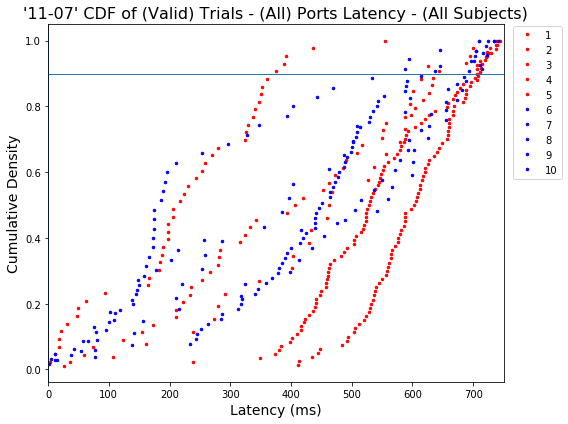

In [39]:
plot_m_latency_cdf(m_latency_df, start_parsetime, box_num="all", threshold=750, valid_trials=True, horizontal=0.9, port_loc='all', save_fig=True)


### Reward Retrieval Latency: 

(needed for TIR-2 and after) ex: TIR-3
- necessary verification step that mouse received reward in the MIDDLE port after their response in the left/right port 
- calculates the latency between the end of solenoid delivery (8270) and FIRST poke in middle port (8071) 

-- Note: should I be doing 7170 / 9170 as the starting reference point? (to be consistent with the response latency calculations above? 

> **Current Logic:**  
Start --> 8270 (end of reward)   
End --> 8271 (FIRST poke in) 



## TESTTEST

In [40]:
# # Only need the event codes! to determine trial type and trial location
# # Also, 'end_event_codes' uniquely determine the trial type and port location
# # one to many relationship in terms of (start) --> (end)

def get_i_response_latency(i_df, start_array, end_array):    
    
    """
    - ****** will only work for global latencies (such as trial latency etc.)
    - will not contain port information nor valid, invalid information
    - basically use this if start_array and end array have on elements each! 
    
    - will now have all of the above information! (10/8)
    
    :i_df: individual dataframe parsed out from the multi-level dataframe
    :start_array: start time code
    :end_array: end time code
    """

    # make dataframes out of trial start / trial end 
    start_code_df = i_df.loc[i_df.event_code.isin(start_array)]
    end_code_df = i_df.loc[i_df.event_code.isin(end_array)]
    
    # OUTER IF --> determines FIRST ROW modification
    if (start_code_df.iloc[0]['timestamp'] <= end_code_df.iloc[0]['timestamp']): 
        
        # INNER IF --> determines LAST ROW modification
        # Case 1 (no modifications)  
        if (start_code_df.iloc[-1]['timestamp'] <= end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df.timestamp.tolist()
            end_time = end_code_df.timestamp.tolist()
            event_code = end_code_df.event_code.tolist()
#             print("case 1")

        # Case 2 (Drop LAST row in START)
        elif (start_code_df.iloc[-1]['timestamp'] > end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df[:-1].timestamp.tolist()  # drop the last row of start
            end_time = end_code_df.timestamp.tolist()
            event_code = end_code_df.event_code.tolist()
#             print("case 2")
    
    # OUTER IF --> determines FIRST ROW modification
    elif (start_code_df.iloc[0]['timestamp'] > end_code_df.iloc[0]['timestamp']):

        # INNER IF --> determines LAST ROW modification
        # Case 3 (Drop FIRST row in END)
        if start_code_df.iloc[-1]['timestamp'] <= end_code_df.iloc[-1]['timestamp']:
            start_time = start_code_df.timestamp.tolist()
            end_time = end_code_df[1:].timestamp.tolist()   # drop the first row of end
            event_code = end_code_df[1:].event_code.tolist()
#             print("case 3")
            
        # Case 4 (Drop FIRST row in END) + (Drop LAST row in START)
        elif (start_code_df.iloc[-1]['timestamp'] > end_code_df.iloc[-1]['timestamp']):
            start_time = start_code_df[:-1].timestamp.tolist()  # drop the last row of start
            end_time = end_code_df[1:].timestamp.tolist()   # drop the first row of end
            event_code = end_code_df[1:].event_code.tolist()
#             print("case 4")

    
    latency_df = pd.DataFrame(zip(start_time, end_time, event_code), columns=['start_time','end_time','event_code'])
    latency_df['latency'] = latency_df.end_time - latency_df.start_time
    latency_df['location'] = latency_df.event_code.str[0]
    
    
    code_info_latency = latency_df[['event_code','latency','location']]

    return code_info_latency
    

In [41]:
start_point = ['8270']   # end of solenoid reward
end_point = ['8071']     # poke in @ middle port 

In [42]:
## rr = reward retrieval latency 
## individual reward retrieval latency 

def get_i_rr_latency(i_df, start_point, end_point):
    
    reward_df = i_df[i_df.event_code.isin(start_point)]
    reward_index = reward_df.index
    poke_in_df = i_df[i_df.event_code.isin(end_point)]
    poke_index = poke_in_df.index
    
    first_poke_array = []
    
    for i in reward_index:

        boolean_arrays = np.where(poke_index > i)[0]  # returns the true values where the poke in mid follows end of reward! 
        first_poke = boolean_arrays[0]                # from the true value array, returns the first index (first poke) 
        first_poke_array.append(first_poke)

    retrieval_idx = poke_index[first_poke_array]                      # map it to original poke index to get the REAL index 
    
    return (reward_index, retrieval_idx) #poke_in_df.index[-5:]

In [44]:
# a,b=get_i_rr_latency(tir2_box3, start_point, end_point)

In [ ]:
a

In [ ]:
b

In [ ]:
## Get the Reward Index  --> This will be the reference timer (starting point)!! (will stay the same!! )

reward_df = tir2_box3[tir2_box3.event_code == '8270']   # solenoid off code 
reward_df.shape
# reward_off_df.head(3)
reward_index = reward_df.index
# len(reward_index)

In [ ]:
## Get the Retrieval Index  --> This will be dependent on Reward Index (since reward index is the reference point)

poke_in_df = tir2_box3[tir2_box3.event_code == '8071']   # Middle port poke in code 
poke_in_df.shape
# poke_in_df.head(3)
poke_index = poke_in_df.index
# len(poke_index)

In [ ]:
reward_index[:10]

In [ ]:
poke_index[-5:]

### NOTES
Reward Retrieval is defined by the FIRST poke in middle port following the END of reward delivery.
In example above, 
1. 2699 (end of reward) --> 2701 (FIRST Poke in mid port) 
2. 2744 (end of reward) --> 2747 (FIRST Poke in mid port) 
3. 2783 (end of reward) --> 2785 (FIRST Poke in mid port)    

Mouse CAN retrieve reward or NOT! (mouse doesn't have to receive the reward, so don't assume that a poke will always be present. It could be zero too!! 

- thus need to get the index in between 

In [ ]:
# tir2_box3.loc[2780:2800]

In [ ]:
reward_index

In [ ]:
retrieval_idx

In [45]:
first_poke_array = []
for i in reward_index:

    boolean_arrays = np.where(poke_index > i)[0]  # returns the true values where the poke in mid follows end of reward! 
    first_poke = boolean_arrays[0]                # from the true value array, returns the first index (first poke) 
    first_poke_array.append(first_poke)
    
    
retrieval_idx = poke_index[first_poke_array]                      # map it to original poke index to get the REAL index 

NameError: name 'reward_index' is not defined

In [ ]:
def latency_idx_check(self):
    assert len(reward_index) != len(retrieval_idx)
    print("pass")

#### Reward DF and FIRST poke DF (retrieval)

In [ ]:
reward_df = tir2_box3[tir2_box3.event_code == '8270']
reward_df.head()

In [ ]:
28600971.0 - 28602904.0

In [ ]:
reward_index

In [ ]:
# tir2_box3[120:150]

In [ ]:
retrieval_df = tir2_box3.loc[retrieval_idx]

In [ ]:
reward_time = reward_df.timestamp.tolist()
reward_time
retrieval_time = retrieval_df.timestamp.tolist()
# retrieval_time

In [ ]:
# pd.concat([reward_time, retrieval_time], axis=1)

In [ ]:
## Need to make it into a list first!! and then zip it and make into dataframe

rr_latency_df = pd.DataFrame(zip(reward_time, retrieval_time), columns =["reward","retrieval"])
rr_latency_df['latency'] = rr_latency_df.retrieval - rr_latency_df.reward
# rr_latency_df

In [ ]:
result_idx = []
for i in sol_off_idx:
#     print(i)
   
    if (poke_index > i).any():
        all_true_arrays = np.where(poke_index > i)
        first_poke = all_true_arrays[0][0]
    
    result_idx.append(first_poke)


In [ ]:
# np.where(poke_index > 3000)[0]

In [ ]:
poke_in_df = tir2_box3[tir2_box3.event_code == '8071']
poke_in_df.head(30)
poke_index = poke_in_df.index

### TEST

In [ ]:
m_head_dict['3']['Start Date']

In [ ]:
## individual box
tir2_box3 = m_parsed_dt_df['3'].dropna(how='all')
tir2_box3.shape

In [ ]:
tir2_box3.index

### Reward Retrieval Latency: 

Potentially this logic? 


Start --> 8270 (end of reward) ?? 
End --> 8271 (start of poke in) ?? 

Get the index of '8270' (end of reward) 



In [ ]:
# tir2_box3[70:90]

In [ ]:
## Get the Reward Index  --> This will be the reference timer (starting point)!! (will stay the same!! )

reward_df = tir2_box3[tir2_box3.event_code == '8270']   # solenoid off code 
reward_df.shape
# reward_off_df.head(3)
reward_index = reward_df.index
# len(reward_index)

In [ ]:
## Get the Retrieval Index  --> This will be dependent on Reward Index (since reward index is the reference point)

poke_in_df = tir2_box3[tir2_box3.event_code == '8071']   # Middle port poke in code 
poke_in_df.shape
# poke_in_df.head(3)
poke_index = poke_in_df.index
# len(poke_index)

In [ ]:
reward_index[:10]

In [ ]:
poke_index[-5:]

### NOTES
Reward Retrieval is defined by the FIRST poke in middle port following the END of reward delivery.
In example above, 
1. 2699 (end of reward) --> 2701 (FIRST Poke in mid port) 
2. 2744 (end of reward) --> 2747 (FIRST Poke in mid port) 
3. 2783 (end of reward) --> 2785 (FIRST Poke in mid port)    

Mouse CAN retrieve reward or NOT! (mouse doesn't have to receive the reward, so don't assume that a poke will always be present. It could be zero too!! 

- thus need to get the index in between 

In [ ]:
tir2_box3.loc[2780:2800]

In [ ]:
reward_index

In [ ]:
retrieval_idx

In [ ]:
ret_idxtest = retrieval_idx[:-2]
ret_idxtest.shape

In [ ]:

for i, j in zip(reward_index, retrieval_idx):
#     print(j - (i+1))
#     print(i+1)
#     k += 1
#     print(k)

In [ ]:
first_poke_array = []
for i in reward_index:

    boolean_arrays = np.where(poke_index > i)[0]  # returns the true values where the poke in mid follows end of reward! 
    first_poke = boolean_arrays[0]                # from the true value array, returns the first index (first poke) 
    first_poke_array.append(first_poke)
    
    
retrieval_idx = poke_index[first_poke_array]                      # map it to original poke index to get the REAL index 

In [ ]:
def latency_idx_check(self):
    assert len(reward_index) != len(retrieval_idx)
    print("pass")

#### Reward DF and FIRST poke DF (retrieval)

In [ ]:
reward_df = tir2_box3[tir2_box3.event_code == '8270']
reward_df.head()

In [ ]:
28600971.0 - 28602904.0

In [ ]:
reward_index

In [ ]:
tir2_box3[120:150]

In [ ]:
retrieval_df = tir2_box3.loc[retrieval_idx]

In [ ]:
reward_time = reward_df.timestamp.tolist()
reward_time
retrieval_time = retrieval_df.timestamp.tolist()
# retrieval_time

In [ ]:
# pd.concat([reward_time, retrieval_time], axis=1)

In [ ]:
## Need to make it into a list first!! and then zip it and make into dataframe

rr_latency_df = pd.DataFrame(zip(reward_time, retrieval_time), columns =["reward","retrieval"])
rr_latency_df['latency'] = rr_latency_df.retrieval - rr_latency_df.reward
# rr_latency_df

In [ ]:
result_idx = []
for i in sol_off_idx:
#     print(i)
   
    if (poke_index > i).any():
        all_true_arrays = np.where(poke_index > i)
        first_poke = all_true_arrays[0][0]
    
    result_idx.append(first_poke)


In [ ]:
# np.where(poke_index > 3000)[0]

In [ ]:
poke_in_df = tir2_box3[tir2_box3.event_code == '8071']
poke_in_df.head(30)
poke_index = poke_in_df.index

### Plotting Functions

In [ ]:
## later put in arguments for parsing out maximum time + valid/invalid

def plot_latency_cdf(m_latency_df):

    result = []; box_arr = list(m_latency_df.columns.levels[0])
    midx_shape = m_latency_df.columns.levshape   # (returns a tuple)
    
    plt.figure(figsize=(10,8))
    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]
           
        ind_df = m_latency_df.loc[:, box_num]
        ind_df = ind_df.dropna(how='all')
        
        x, y = ecdf_wo_nan(ind_df.latency)
        
        adults = {'1','2','3','4','5'}  # using a set
        adolescents = {'6','7','8','9','10'}

        if box_num in adults:
            plt.plot(x, y, marker='.', linestyle= 'none', ms= 5, color='blue', label='adult')
        elif box_num in adolescents:
            plt.plot(x, y, marker='.', linestyle= 'none', ms= 5, color='red', label="adol")

    plt.axhline(0.9)

    plt.ylabel("Cumulative Density Function", fontsize=14)
    plt.xlabel("Latency (ms)", fontsize=14)
    # plt.legend(handles=[line1, line2], loc='lower right')
    plt.title("CDF of Valid Rewards Latency ({}) - Blue:Adults/Red:Adol" , fontsize=16)
    plt.xlim([0,5000])
    # # Display the plot
    plt.show()

    # plt.plot(x, y, marker= '.', linestyle= 'none', ms= 2)
    # plt.savefig("data/cdf0903.png")


In [ ]:
x, y = ecdf(rr_latency_df.latency)

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(x,y, marker='.', linestyle= 'none', ms=5)

### Annotated Snippets of Functions

In [ ]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    # n = data.count() --> can't do this bc dimensions of x and y need to be identical
    
    ## Use this when only dealing with one file --> with multilevel dataframes, will drop nan values as intermediary step
    # Drop the nan values for normalization!! 
#   # data = data.dropna(how='all')
#   # x = data

    # x-data for the ECDF after dropping nan values: x
    x = np.sort(data)

    n = len(data)    
    
    # y-data for the ECDF: y   --> essentially like np.linspace
    #                             (each data point gets the same number of percentage point)
    #                             (y-increment is the same for data point(x))
    y = np.arange(1, n+1) / n

    return x, y

<a href='#Table of Contents'>Back to Table of Contents</a>

<a href='#Table of Contents'>Back to Table of Contents</a>

<a id='Event Code'></a>
___
### Appendix:

***Event Codes***

In [7]:

event_code_dict = {'7071' :'L_Poke_Valid_IN',  '7171' :'L_led_Valid_ON',  '7271' :'L_sol_Valid_ON',
                   '7070' :'L_Poke_Valid_OUT', '7170' :'L_led_Valid_OFF', '7270' :'L_sol_Valid_OFF',
                   '8071' :'M_Poke_Valid_IN',  '8171' :'M_led_Valid_ON',  '8271' :'M_sol_Valid_ON',
                   '8070' :'M_Poke_Valid_OUT', '8170' :'M_led_Valid_OFF', '8270' :'M_sol_Valid_OFF',
                   '9071' :'R_Poke_Valid_IN',  '9171' :'R_led_Valid_ON',  '9271' :'R_sol_Valid_ON',
                   '9070' :'R_Poke_Valid_OUT', '9170' :'R_led_Valid_OFF', '9270' :'R_sol_Valid_OFF',

                   '7160' :'L_led_Invalid_OFF',
                   '8160' :'M_led_Invalid_OFF',
                   '9160' :'R_led_Invalid_OFF',

                   '7519' :'L_iw',  '7529' :'L_tw',  '7539' :'L_vw', '7559' :'L_delay_w',
                   '8519' :'M_iw',  '8529' :'M_tw',  '8539' :'M_vw', '8559' :'M_delay_w',
                   '9519' :'R_iw',  '9529' :'R_tw',  '9539' :'R_vw', '9559' :'R_delay_w',

                   '7540' :'Left_Omission', '8540' :'Middle_Omission', '9540' :'Right_Omission',

                   '5520' :'Trial_Window_End',
                   '5521' :'Trial_Window_Start',

                   '0114' :'END'}




<a href='#data wrangling'>Back to Initial Data Wrangling</a>

<a href='#return_body_df'>Back to return-body-df function</a>

<a href='#Table of Contents'>Back to Table of Contents</a>

In [ ]:
tir_1.to_csv("Final_Metrics/0925_TIR.csv")

<a href='#Table of Contents'>Back to Table of Contents</a>